In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time

import matplotlib.pyplot as plt
plt.style.use('dark_background')

import jax
import jax.numpy as jnp
from jax import random

from tqdm.notebook import tqdm

# Kernelizing a kernel function

This notebooks serves to demonstrate the usefulness of the `kernelize` decorator.

This idea can be found in https://github.com/google/jax/blob/main/examples/gaussian_process_regression.py, under the name of `cov_map` (but in that example the order of the arguments is inverted...).
In addition to the above cited implementation, in `gpx` there is also another implementation that makes use of the `jax.lax` operations to obtain the same result.

The `kernelize` decorator takes as input a kernel function, and gives back a kernel function operating on batches of data.
It is very useful as the input kernel function, which we call `kernel_base`, is written taking as input a single data point, while the output of the `kernelize` function takes as input an entire dataset.

We write our simple `kernel_base` as:

In [3]:
def kernel_base(x1, x2, params):
    return jnp.exp(-jnp.sum((x1 - x2)**2))

This function has the same signature of the `gpx` kernels, but does not make use of the `params` argument, just to keep it simple.

Now we can generate a dataset

In [4]:
x = random.normal(random.PRNGKey(2023), shape=(100, 3))

We can test that our kernel function works for a single data point

In [5]:
kernel_base(x[0], x[1], None)

DeviceArray(0.26659128, dtype=float32)

But it does not work (or at least, it does not work as intended) if we give as input the whole dataset

In [6]:
kernel_base(x, x, None)

DeviceArray(1., dtype=float32)

Which, obviously, does not make sense.

We could write manually a function that works on batches of data as:

In [7]:
def kernel_vectorized(x1, x2, params):
    return jnp.exp(-jnp.sum((x1[:, None] - x2)**2, axis=-1))

In [8]:
kernel_vectorized(x, x, None)

DeviceArray([[1.00000000e+00, 2.66591281e-01, 3.41801369e-03, ...,
              6.84892757e-06, 3.81131262e-01, 6.28447160e-02],
             [2.66591281e-01, 1.00000000e+00, 5.40796435e-04, ...,
              2.62472131e-05, 4.19877544e-02, 1.31704435e-02],
             [3.41801369e-03, 5.40796435e-04, 1.00000000e+00, ...,
              5.53209409e-02, 8.84467154e-04, 8.19180347e-03],
             ...,
             [6.84892757e-06, 2.62472131e-05, 5.53209409e-02, ...,
              1.00000000e+00, 1.29801776e-06, 2.07671459e-04],
             [3.81131262e-01, 4.19877544e-02, 8.84467154e-04, ...,
              1.29801776e-06, 1.00000000e+00, 3.06320637e-01],
             [6.28447160e-02, 1.31704435e-02, 8.19180347e-03, ...,
              2.07671459e-04, 3.06320637e-01, 1.00000000e+00]],            dtype=float32)

Which in this case is of course very simple. Note however that this function stores a lot of distances in memory, and so it will raise an out of memory error as the dataset size increases.

The `kernelize` decorator writes the batched version of the function for us.
It can do that in two ways: by creating the batched version making use of the `jax.vmap` function, or by creating the batched version making use of the `jax.lax.fori_loop` function.

The first one is faster for small datasets, as, like our manual version, stores in memory a lot of data.
The second one is slower, but scales much better for bigger datasets.
Let's try both:

In [9]:
from gpx.kernels.kernelizers import kernelize

kernel_vmap = kernelize(kernel_base, lax=False)
kernel_lax = kernelize(kernel_base, lax=True)

In [10]:
kernel_vmap(x, x, None)

DeviceArray([[1.00000000e+00, 2.66591281e-01, 3.41801369e-03, ...,
              6.84892757e-06, 3.81131262e-01, 6.28447160e-02],
             [2.66591281e-01, 1.00000000e+00, 5.40796435e-04, ...,
              2.62472131e-05, 4.19877544e-02, 1.31704435e-02],
             [3.41801369e-03, 5.40796435e-04, 1.00000000e+00, ...,
              5.53209409e-02, 8.84467154e-04, 8.19180347e-03],
             ...,
             [6.84892757e-06, 2.62472131e-05, 5.53209409e-02, ...,
              1.00000000e+00, 1.29801776e-06, 2.07671459e-04],
             [3.81131262e-01, 4.19877544e-02, 8.84467154e-04, ...,
              1.29801776e-06, 1.00000000e+00, 3.06320637e-01],
             [6.28447160e-02, 1.31704435e-02, 8.19180347e-03, ...,
              2.07671459e-04, 3.06320637e-01, 1.00000000e+00]],            dtype=float32)

In [11]:
kernel_lax(x, x, None)

DeviceArray([[1.00000000e+00, 2.66591281e-01, 3.41801369e-03, ...,
              6.84892757e-06, 3.81131262e-01, 6.28447160e-02],
             [2.66591281e-01, 1.00000000e+00, 5.40796435e-04, ...,
              2.62472131e-05, 4.19877544e-02, 1.31704435e-02],
             [3.41801369e-03, 5.40796435e-04, 1.00000000e+00, ...,
              5.53209409e-02, 8.84467154e-04, 8.19180347e-03],
             ...,
             [6.84892757e-06, 2.62472131e-05, 5.53209409e-02, ...,
              1.00000000e+00, 1.29801776e-06, 2.07671459e-04],
             [3.81131262e-01, 4.19877544e-02, 8.84467154e-04, ...,
              1.29801776e-06, 1.00000000e+00, 3.06320637e-01],
             [6.28447160e-02, 1.31704435e-02, 8.19180347e-03, ...,
              2.07671459e-04, 3.06320637e-01, 1.00000000e+00]],            dtype=float64)

The output is the same:

In [12]:
assert jnp.allclose(kernel_vmap(x, x, None), kernel_lax(x, x, None))

To demonstrate the strengths and the weaknesses of each one, we can compute the time required by each one to compute the kernel matrix for increasing number of samples:

In [13]:
lax_times = []
vmap_times = []

for n in tqdm([5, 10, 100, 500, 1000, 1500, 2000, 5000, 6000, 7000, 8000, 9000, 10000]):
    x = jax.random.normal(jax.random.PRNGKey(2023), shape=(n, 100))
    
    try:
        start = time.perf_counter()
        _ = kernel_lax(x, x, None).block_until_ready()
        lax_times.append(time.perf_counter() - start)
    except Exception as e:
        print('lax version failed:', e)
    
    try:
        start = time.perf_counter()
        _ = kernel_vmap(x, x, None).block_until_ready()
        vmap_times.append(time.perf_counter() - start)
    except Exception as e:
        print('vmap version failed:', e)

  0%|          | 0/13 [00:00<?, ?it/s]

vmap version failed: RESOURCE_EXHAUSTED: Out of memory allocating 20800000000 bytes.
vmap version failed: RESOURCE_EXHAUSTED: Out of memory allocating 29952000000 bytes.
vmap version failed: RESOURCE_EXHAUSTED: Out of memory allocating 40768000000 bytes.
vmap version failed: RESOURCE_EXHAUSTED: Out of memory allocating 53248000000 bytes.
vmap version failed: RESOURCE_EXHAUSTED: Out of memory allocating 67392000000 bytes.
vmap version failed: RESOURCE_EXHAUSTED: Out of memory allocating 83200000000 bytes.


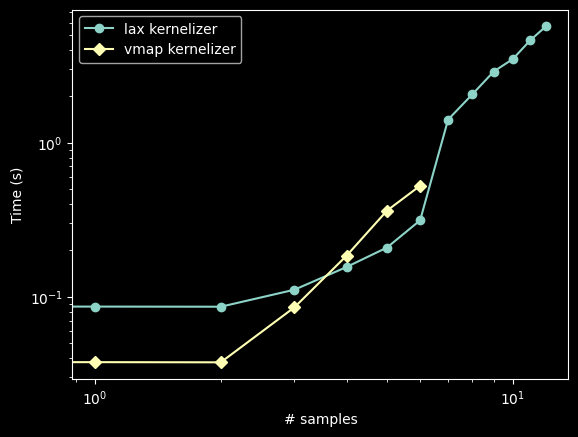

In [14]:
plt.plot(lax_times, '-o', label='lax kernelizer')
plt.plot(vmap_times, '-D', label='vmap kernelizer')
plt.loglog()
plt.ylabel('Time (s)')
plt.xlabel('# samples')
plt.legend()

Which shows that the `vmap` version works great for a small number of samples, but as the number of samples increases, (1) it becomes slower, and (2) it eventually breaks as it cannot allocate in memory all the data it needs. The `jax.lax` implementation, on the other hand, works seamlessly for all the dataset sizes tested in this notebok.